In [1]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [154]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.common.value import AbstractValue
from pydrake.geometry import SceneGraphConfig, StartMeshcat, FramePoseVector, GeometryFrame
from pydrake.systems.framework import Context, LeafSystem, BasicVector
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer
from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController, PendulumPlant
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource, LeafSystem, MultibodyPositionToGeometryPose,
    Multiplexer, ConstantVectorSource, Context, ContinuousState, MeshcatVisualizer, Demultiplexer, ConstantValueSource, LinearQuadraticRegulator,
CompositeTrajectory, VectorLogSink
)
from pydrake.solvers import MathematicalProgram, Solve, OsqpSolver
from IPython.display import SVG, display
import pydot
import math

import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import HTML, SVG, Latex, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ConstantVectorSource,
                         DiagramBuilder, FirstOrderTaylorApproximation,
                         LinearQuadraticRegulator, MatrixGain,
                         MeshcatVisualizer, MultibodyPlant, Parser,
                         Saturation, SceneGraph, Simulator, StartMeshcat,
                         WrapToSystem)
from pydrake.common.containers import namedview

## 0. Calculating Jacobians for Continuous Linearized Dynamics

This was also done in MATLAB.

In [80]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import time
from IPython.display import display

def get_symbolic_linearized_dynamics():
    start_time = time.perf_counter()
    
    print(f"Start creating symbolic linearized dynamics")
    t = me.dynamicsymbols._t

    # Constants
    Mq, Lq, Lp, g, kF, kM = sm.symbols('Mq, Lq, Lp, g, kF, kM', real=True)
    Ixx, Iyy, Izz = sm.symbols('Ixx, Iyy, Izz', real=True)
    I = sm.Matrix([[Ixx, 0, 0], 
               [0, Iyy, 0],
                [0, 0, Izz]])

    # State Variables
    Px, Py, Pz, Phi, Theta, Psi, Pa, Pb = me.dynamicsymbols('Px Py Pz Phi Theta Psi Pa Pb', real=True)
    Wx, Wy, Wz = sm.symbols('Wx Wy Wz', real=True)
    P = sm.Matrix([Px, Py, Pz])
    Q = sm.Matrix([Phi, Theta, Psi])
    V = P.diff(t)
    W = sm.Matrix([Wx, Wy, Wz])

    # Control Variables 
    u = sm.Matrix(me.dynamicsymbols('u0:4', real=True))
    B = sm.Matrix([
            [kF, kF, kF, kF],
            [0, Lq*kF, 0, -Lq*kF],
            [-Lq*kF, 0 , Lq*kF, 0],
            [kM, -kM, kM, -kM]
        ])
    
    f = B * u
    Fz = f[0]
    T =  sm.Matrix(f[1:4])
    display(T)
    
    Fg = sm.Matrix([0, 0, Mq * g])
    display(Fg)
    
    
    gq = sm.Matrix([sm.sin(Phi)*sm.sin(Psi) + sm.cos(Phi)*sm.sin(Theta)*sm.cos(Psi), 
                  -sm.sin(Phi)*sm.cos(Psi) + sm.cos(Phi)*sm.sin(Theta)*sm.sin(Psi),
                  sm.cos(Phi)*sm.cos(Theta)])
    display(gq)
    
    Pddt = (Fg + gq * Fz)/Mq
    display(Pddt)
    
    Zq = sm.Matrix([[ 1, sm.sin(Phi)*sm.tan(Theta), sm.cos(Phi)*sm.tan(Theta)],
                   [0, sm.cos(Phi), -sm.sin(Phi)],
                   [0, sm.sin(Phi)/sm.cos(Theta), sm.cos(Phi)/sm.cos(Theta)]])
    display(Zq)
    
    Qdt = Zq * W
    display(Qdt)
    Wdt = (I**-1) * (I * W).cross(W) + (I**-1) * T
    display(Wdt)
    
    a, b = Pa, Pb
    a2 = pow(a,2)
    b2 = pow(b,2)
    ad = Pa.diff(t)
    bd = Pb.diff(t)
    ad2 = pow(ad,2)
    bd2 = pow(bd,2)
    Lp2 = pow(Lp,2)
    
    eta = sm.sqrt(Lp2 - a2 - b2)
    
    Hab = 4*bd2*(a2 - Lp2) - 8*ad*bd*a*b + 4*ad2*(b2 - Lp2) + 3*pow(eta,3)*g
    Fp = sm.Matrix([
        (a*Hab)/(4*Lp2*pow(eta,2)),
        (b*Hab)/(4*Lp2*pow(eta,2))
    ])
    Bp = sm.Matrix([[ 3*(a2 -Lp2)/(4*Lp2), (3*a*b)/(4*Lp2), (3*a*eta)/(4*Lp2)],
                  [(3*a*b)/(4*Lp2), 3*(b2 - Lp2)/(4*Lp2), (3*b*eta)/(4*Lp2)]])
    
    PDddt = Fp + Bp * Pddt
    
    DDt = sm.Matrix([
        V[0],
        V[1],
        V[2],
        Qdt[0],
        Qdt[1],
        Qdt[2],
        ad,
        bd,
        Pddt[0],
        Pddt[1],
        Pddt[2],
        Wdt[0],
        Wdt[1],
        Wdt[2],
        PDddt[0],
        PDddt[1],
    ]).T
    display(DDt.T)
    x = sm.Matrix([Px, Py, Pz, Phi, Theta, Psi, Pa, Pb, V[0], V[1], V[2], W[0], W[1], W[2], ad, bd]).T
    u = sm.Matrix([u[0], u[1], u[2], u[3]]).T
    
    A = sm.trigsimp(DDt.jacobian(x))
    display(A)
    B = sm.trigsimp(DDt.jacobian(u))
    display(B)

    sym_vars = [Mq, Lq, Lp, g, kF, kM, Ixx, Iyy, Izz, Px, Py, Pz, Phi, Theta, Psi, a, b, V[0], V[1], V[2], W[0], W[1], W[2], ad, bd, u[0], u[1], u[2], u[3]]
    A_lambdified = sm.lambdify(sym_vars, A)
    B_lambdified = sm.lambdify(sym_vars, B)
    xdot_lambdified = sm.lambdify(sym_vars, DDt)
    print(
        f"Finished creating symbolic linearized dynamics after {time.perf_counter() - start_time:.1f} seconds"
    )
    return A_lambdified, B_lambdified, xdot_lambdified

In [81]:
A_lambdified, B_lambdified, xdot_lambdified = get_symbolic_linearized_dynamics()

Start creating symbolic linearized dynamics


Matrix([
[                Lq*kF*u1(t) - Lq*kF*u3(t)],
[               -Lq*kF*u0(t) + Lq*kF*u2(t)],
[kM*u0(t) - kM*u1(t) + kM*u2(t) - kM*u3(t)]])

Matrix([
[   0],
[   0],
[Mq*g]])

Matrix([
[ sin(Phi(t))*sin(Psi(t)) + sin(Theta(t))*cos(Phi(t))*cos(Psi(t))],
[-sin(Phi(t))*cos(Psi(t)) + sin(Psi(t))*sin(Theta(t))*cos(Phi(t))],
[                                       cos(Phi(t))*cos(Theta(t))]])

Matrix([
[ (sin(Phi(t))*sin(Psi(t)) + sin(Theta(t))*cos(Phi(t))*cos(Psi(t)))*(kF*u0(t) + kF*u1(t) + kF*u2(t) + kF*u3(t))/Mq],
[(-sin(Phi(t))*cos(Psi(t)) + sin(Psi(t))*sin(Theta(t))*cos(Phi(t)))*(kF*u0(t) + kF*u1(t) + kF*u2(t) + kF*u3(t))/Mq],
[                                (Mq*g + (kF*u0(t) + kF*u1(t) + kF*u2(t) + kF*u3(t))*cos(Phi(t))*cos(Theta(t)))/Mq]])

Matrix([
[1, sin(Phi(t))*tan(Theta(t)), cos(Phi(t))*tan(Theta(t))],
[0,               cos(Phi(t)),              -sin(Phi(t))],
[0, sin(Phi(t))/cos(Theta(t)), cos(Phi(t))/cos(Theta(t))]])

Matrix([
[Wx + Wy*sin(Phi(t))*tan(Theta(t)) + Wz*cos(Phi(t))*tan(Theta(t))],
[                                 Wy*cos(Phi(t)) - Wz*sin(Phi(t))],
[     Wy*sin(Phi(t))/cos(Theta(t)) + Wz*cos(Phi(t))/cos(Theta(t))]])

Matrix([
[                (Iyy*Wy*Wz - Izz*Wy*Wz)/Ixx + (Lq*kF*u1(t) - Lq*kF*u3(t))/Ixx],
[              (-Ixx*Wx*Wz + Izz*Wx*Wz)/Iyy + (-Lq*kF*u0(t) + Lq*kF*u2(t))/Iyy],
[(Ixx*Wx*Wy - Iyy*Wx*Wy)/Izz + (kM*u0(t) - kM*u1(t) + kM*u2(t) - kM*u3(t))/Izz]])

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Derivative(Px(t), t)],
[                                                                                                                                                                                                                                                                                                                               

Matrix([
[0, 0, 0,                                                                                                                                                                                                                                                                                                                                                                                                                              0,                                                                                                                                                                                                                                                                                                                                                                    0,                                                                                                                                                                                                                

Matrix([
[                                                                                                                                                                                                                                                                                                 0,                                                                                                                                                                                                                                                                                                  0,                                                                                                                                                                                                                                                                                                  0,                                                                                                                   

Finished creating symbolic linearized dynamics after 37.2 seconds


In [77]:
x = 0.5*np.ones((29,))
x[2] = 3
A_lambdified(*x)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.10875709,  0.88100115,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.26191137,  0.47942554,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0

## 1. Visualization Module

This module interacts with Drake to visualize the Quadrotor state in Meshcat (simulation environment). It has been implemented in a seperate file.

In [18]:
import IPQGeometry
import importlib
importlib.reload(IPQGeometry)

<module 'IPQGeometry' from '/home/stephen/Workspace/fall-2024/MEAM-5170/project/Inverted-Pendulum-Quadrotor/src/IPQGeometry.py'>

## 2. Dynamics module for Inverted Pendulum Quadrotor

This module either takes 
1. [u1, u2, u3, u4] : The 4 torques on each propeller -or-
2. [Fz, M1, M2, M3] : The vertical propeller forces and the angular torques along X, Y and Z

and calculated the next state of the combined inverted pendulum +  quadrotor system given the current state.

In [32]:
from scipy.spatial.transform import Rotation
import math
from math import sqrt

class InvertedPendulumQuadrotor(LeafSystem):
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, use_propeller_torques:bool=True, kF = 1.0, kM=0.0245):
        LeafSystem.__init__(self)
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp

        self._g = 9.81

        self._kF = kF
        self._kM = kM

        self.use_propeller_torques = use_propeller_torques

        if self.use_propeller_torques:
            self.ip_quadrotor_input_port = self.DeclareVectorInputPort("torques", 4)
        else:
            self.ip_quadrotor_input_port = self.DeclareVectorInputPort("zforce_moments", 4)
            
        self.ip_quadrotor_state = self.DeclareContinuousState(16)
        self.DeclareStateOutputPort("state", self.ip_quadrotor_state)

    def DoCalcTimeDerivatives(self, context:Context, dstate:ContinuousState):
        if self.use_propeller_torques:
            torques = self.EvalVectorInput(context, self.ip_quadrotor_input_port.get_index())
            torques = torques.get_value() if torques else np.array([0, 0, 0, 0])
            
            uF = self._kF*torques
            Fz = np.array([sum(uF)])

            uM = self._kM*torques
            M = np.array([
                self._Lq*(uF[1] - uF[3]),
                self._Lq*(uF[2] - uF[0]),
                uM[0] - uM[1] + uM[2] - uM[3]
            ]).T
        else:
            zforce_moments = self.EvalVectorInput(context, self.ip_quadrotor_input_port.get_index())
            zforce_moments = zforce_moments.get_value() if zforce_moments else np.array([0, 0, 0, 0])
            Fz = np.array([zforce_moments[0]])
            M = np.array(zforce_moments[1:4]).T

        # print(Fz)
        # print(M)


        Fg = np.array([0, 0, -self._Mq * self._g]).T
        #print(Fg)
        # print(Fz)
        # print(M)


        state = context.get_continuous_state_vector().value()
        rpy = state[3:6]
        w = state[11:14]

        phi, theta, psi = tuple(rpy)

        gq = np.array([[np.sin(phi)*np.sin(psi) + np.cos(phi)*np.sin(theta)*np.cos(psi), 
                      -np.sin(phi)*np.cos(psi) + np.cos(phi)*np.sin(theta)*np.sin(psi),
                      np.cos(phi)*np.cos(theta)]]).T

        pDDt = (Fg + gq @ Fz)/self._Mq

        Zq = np.array([[ 1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        qDt = Zq @ w
        wDt = np.linalg.inv(self._Iq) @ np.cross(self._Iq @ w, w) + np.linalg.inv(self._Iq) @ M

        a, b = state[6], state[7]
        a2 = pow(a,2)
        b2 = pow(b,2)
        ad, bd = state[14], state[15]
        ad2 = pow(ad,2)
        bd2 = pow(bd,2)
        Lp2 = pow(self._Lp,2)
        
        eta = math.sqrt(Lp2 - a2 - b2)
        
        Hab = 4*bd2*(a2 - Lp2) - 8*ad*bd*a*b + 4*ad2*(b2 - Lp2) + 3*pow(eta,3)*self._g
        Fp = np.array([
            (a*Hab)/(4*Lp2*pow(eta,2)),
            (b*Hab)/(4*Lp2*pow(eta,2))
        ]).T
        Bp = np.array([[ 3*(a2 -Lp2)/(4*Lp2), (3*a*b)/(4*Lp2), (3*a*eta)/(4*Lp2)],
                      [(3*a*b)/(4*Lp2), 3*(b2 - Lp2)/(4*Lp2), (3*b*eta)/(4*Lp2)]])

        pdDDt = Fp + Bp @ pDDt

        DDt = np.concatenate((state[8:11], qDt.T, state[14:16], pDDt.T, wDt.T, pdDDt.T))
        dstate.SetFromVector(DDt)
        # state_list.append(DDt)
        
        
            
            
        

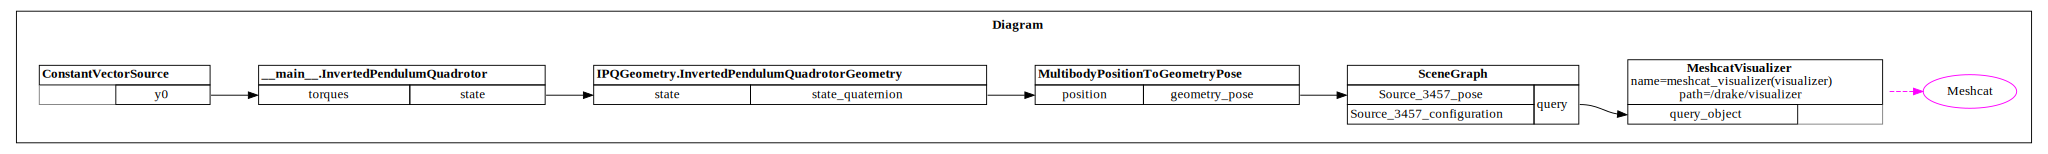

In [93]:
def test_dynamics_and_simulation():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())

    # Apply zero torque
    ud = (plant._Mq*plant._g/4)*np.ones((4,)) 
    constant_torque = builder.AddSystem(ConstantVectorSource(ud))

    # Connect zero torque to dynamics
    builder.Connect(constant_torque.get_output_port(0), plant.get_input_port(0))

    # Connect dynamics to visualization
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()


    context.SetTime(0.)

    initial_state = np.zeros(16,)
    initial_state[6] = 0.1
    # state[4] = +0.4
    # state[6] = -0.02
    context.SetContinuousState(initial_state)
    simulator.Initialize()
    simulator.AdvanceTo(1.2)

test_dynamics_and_simulation()

## 3. MPC Controller

This module calcaultes the next control input given desired state and desired input trajectories using MPC.

In [295]:
from copy import deepcopy
class IPQModelPredictiveController(LeafSystem):
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Q, R, Qf, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, kF = 1.0, kM=0.0245):

        LeafSystem.__init__(self)

        self.Q = Q
        self.R = R
        self.Qf = Qf
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp
        
        self._kF = kF
        self._kM = kM
        self._g = 9.81

        self.umin = 0
        self.umax = 50

        self.n_x = 16
        self.n_u = 4

        ''' Declare Input Ports '''
        # State input port
        self.robot_state_input_port_index = self.DeclareVectorInputPort(
            "x", self.n_x
        ).get_index()
        self.target_robot_state_input_port_index = self.DeclareVectorInputPort(
            "x_d", self.n_x
        ).get_index()
        self.target_torque_output_port = self.DeclareVectorInputPort(
            "u_d", self.n_u
        ).get_index()
        
        # Define the output ports
        self.torque_output_port = self.DeclareVectorOutputPort(
            "u", self.n_u, self.CalcTorques
        )

        self.As, self.Bs, self.xds = A_lambdified, B_lambdified, xdot_lambdified
        
    def x_d(self, t, f:float = 0.5, r:float = 1):
        # return np.array([
        #     r*np.sin(f*t),        #x
        #     r*np.cos(f*t),        #y
        #     1,                    #z
        #     0,                    #Rx
        #     0,                    #Ry
        #     0,                    #Rz
        #     0,                    #a
        #     0,                    #b
        #     r*f*np.cos(f*t),      #Vx
        #     -r*f*np.sin(f*t),     #Vy
        #     0,                    #Vz
        #     0,                    #Wx
        #     0,                    #Wy
        #     0,                    #Wz
        #     0,                    #Va
        #     0                     #Vb
        # ])
        destination = np.zeros((16,))
        destination[2] = 0.4
        return destination

    def u_d(self, t, f:float = 0.5, r:float = 1):
        return np.array([
            self._Mq*self._g/4
        ]*4) # Howering position

    def continuous_time_linearized_dynamics(self, x, u):
        # # Computed using MATLAB
        # Px, Py, Pz, Phi, Theta, Psi, a, b, Vx, Vy, Vz, Wx, Wy, Wz, aD, bD = tuple(x)
        # u1, u2, u3, u4 = tuple(u)

        # uF = self._kF*u
        # Fz = sum(uF)

        # uM = self._kM*u
        # M = np.array([
        #     self._Lq*(uF[1] - uF[3]),
        #     self._Lq*(uF[2] - uF[0]),
        #     uM[0] - uM[1] + uM[2] - uM[3]
        # ]).T

        # C25 = pow(a,2) + pow(b,2) - pow(self._Lp, 2)
        # C24 = pow(a,2) - pow(self._Lp, 2)
        # C23 = pow(b,2) - pow(self._Lp, 2)
        # C22 = -C25

        # C21 = 2*pow(self._Lp,2)*pow(C25, 2)
        # C20 = 4*pow(aD, 2)*C23 + 4*pow(bD,2)*C24 + 3*self._g*pow(C22,3/2) - 8*a*aD
        # C19 = 4*pow(self._Lp, 2)*self._Mq*sqrt(C22)
        # C18 = self._Mq*self._g + Fz*np.cos(Phi)*np.cos(Theta)
        # C17 = 4*pow(self._Lp, 2)*self._Mq

        # C16 = (a*b*C20)/C21
        # C15 = (3*a*b*C18)/C19
        # C14 = (3*C18*sqrt(C22))/C17
        # C13 = 8*bD*C24 - 8*a*aD*bD
        # C12 = 8*aD*C23 - 8*a*b*bD
        # C11 = 8*a*aD*bD - 8*pow(aD,2)*b + 9*b*self._g*sqrt(C22)
        # C10 = 8*aD*b*bD - 8*a*pow(bD,2) + 9*a*self._g*sqrt(C22)

        # C9 = 4*pow(self._Lp,2)*C25

        # C7 = pow(np.tan(Theta), 2) + 1
        # C8 = 2 * pow(self._Lp, 2) * self._Mq

        # C5 = 3*pow(b, 2) - 3*pow(self._Lp, 2)
        # C6 = 3*pow(a, 2) - 3*pow(self._Lp, 2)
        
        # C1 = np.cos(Psi)*np.sin(Phi) - np.cos(Phi)*np.sin(Psi)*np.sin(Theta)
        # C2 = np.sin(Phi)*np.sin(Psi) + np.cos(Phi)*np.cos(Psi)*np.sin(Theta)
        # C3 = np.cos(Phi)*np.sin(Psi) - np.cos(Psi)*np.sin(Phi)*np.sin(Theta)
        # C4 = np.cos(Phi)*np.cos(Psi) + np.sin(Phi)*np.sin(Psi)*np.sin(Theta)

        # A = np.zeros((16, 16))
        # A[0, 8] = 1
        # A[1, 9] = 1
        # A[2, 10] = 1
        
        # A[3, 3] = Wy*np.cos(Phi)*np.tan(Theta) - Wz*np.sin(Phi)*np.tan(Theta)
        # A[3, 4] = Wz*np.cos(Phi)*C7 + Wy*np.sin(Phi)*C7
        # A[3, 11] = 1
        # A[3, 12] = np.sin(Phi)*np.tan(Theta)
        # A[3, 13] = np.cos(Phi)*np.tan(Theta)

        # A[4, 3] = -Wz*np.cos(Phi) - Wy*np.sin(Phi)
        # A[4, 12] = np.cos(Phi)
        # A[4, 13] = -np.sin(Phi)

        # A[5, 3] = Wy*np.cos(Phi)/np.cos(Theta) - Wz*np.sin(Phi)/np.cos(Theta)
        # A[5, 4] = Wz*np.cos(Phi)*np.sin(Theta)/pow(np.cos(Theta),2) - Wy*np.sin(Phi)*np.sin(Theta)/pow(np.cos(Theta), 2)
        # A[5, 12] = np.sin(Phi)/np.cos(Theta)
        # A[5, 13] = np.cos(Phi)/np.cos(Theta)

        # A[6, 14] = 1
        # A[7, 15] = 1

        # A[8, 3] = Fz*C3/self._Mq
        # A[8, 4] = Fz*np.cos(Phi)*np.cos(Psi)*np.cos(Theta)/self._Mq
        # A[8, 5] = Fz*C1/self._Mq
        
        # A[9, 3] = -Fz*C4/self._Mq
        # A[9, 4] = Fz*np.cos(Phi)*np.sin(Psi)*np.cos(Theta)/self._Mq
        # A[9, 5] = Fz*C2/self._Mq

        # A[10, 3] = -Fz*np.cos(Theta)*np.sin(Phi)/self._Mq
        # A[10, 4] = -Fz*np.cos(Phi)*np.sin(Theta)/self._Mq
        # A[10, 5] = 0

        # Ixx = self._Iq[0, 0]
        # Iyy = self._Iq[1, 1]
        # Izz = self._Iq[2, 2]
        
        # A[11, 12] = (Iyy*Wz - Izz*Wz)/Ixx
        # A[11, 13] = (Iyy*Wy - Izz*Wy)/Ixx

        # A[12, 11] = -(Ixx*Wz - Izz*Wz)/Iyy
        # A[12, 13] = -(Ixx*Wx - Izz*Wx)/Iyy

        # A[13, 11] = (Ixx*Wy - Iyy*Wy)/Izz
        # A[13, 12] = (Ixx*Wx - Iyy*Wx)/Izz

        # A[14, 3] = (Fz*C6*C3 - 3*a*b*Fz*C4 - 3*a*Fz*np.cos(Theta)*np.sin(Phi)*sqrt(C22))/C17
        # A[14, 4] = (Fz*np.cos(Phi)*np.cos(Theta)*np.cos(Psi)*C6 - 3*a*Fz*np.cos(Phi)*np.sin(Theta)*sqrt(C22) + 3*a*b*Fz*np.cos(Phi)*np.cos(Theta)*np.sin(Psi))/C17
        # A[14, 5] = (Fz*C6*C1 + 3*a*b*Fz*C2)/C17
        # A[14, 6] = a*C10/C9 - C20/C9 + pow(a, 2)*C20/C21 + C14 - 3*pow(a,2)*C18/C19 + 3*a*Fz*C2/C8 - 3*b*Fz*C1/C17
        # A[14, 7] = a*C11/C9 + C16 - 3*a*Fz*C1/C17 - C15
        # A[14, 14] = -a*C12/C9
        # A[14, 15] = -a*C13/C9

        # A[15, 3] = (-Fz*C5*C4 + 3*a*b*Fz*C3 - 3*b*Fz*np.cos(Theta)*np.sin(Phi)*sqrt(C22))/C17
        # A[15, 4] = (Fz*np.cos(Phi)*np.cos(Theta)*np.sin(Psi)*C5 - 3*b*Fz*np.cos(Phi)*np.sin(Theta)*sqrt(C22) + 3*a*b*Fz*np.cos(Phi)*np.cos(Theta)*np.cos(Psi))/C17
        # A[15, 5] = (Fz*C5*C2 + 3*a*b*Fz*C1)/C17
        # A[15, 6] = b*C10/C9 + C16 + 3*b*Fz*C2/C17 - C15
        # A[15, 7] = b*C11/C9 - C20/C9 + pow(b, 2)*C20/C21 + C14 - 3*pow(b,2)*C18/C19 + 3*a*Fz*C2/C17 - 3*b*Fz*C1/C8
        # A[15, 14] = -b*C12/C9
        # A[15, 15] = -b*C13/C9

        # D8 = np.sin(Phi)*np.cos(Psi) - np.cos(Phi)*np.sin(Psi)*np.sin(Theta)
        # D7 = sqrt(C22)
        # D6 = 4*pow(self._Lp,2)*self._Mq
        # D5 = np.sin(Phi)*np.sin(Psi) + np.cos(Phi)*np.cos(Psi)*np.sin(Theta)
        # D4 = -self._kF*D8/self._Mq
        # D3 = (3*a*self._kF*np.cos(Phi)*np.cos(Theta)*D7 - 3*a*b*self._kF*D8 - self._kF*D5*(3*pow(self._Lp, 2) - 3*pow(a,2)))/D6 
        # D2 = (3*b*self._kF*np.cos(Phi)*np.cos(Theta)*D7 + 3*a*b*self._kF*D5 + self._kF*D8*(3*pow(self._Lp, 2) - 3*pow(b,2)))/D6 
        # D1 = (self._kF*np.cos(Phi)*np.cos(Theta))/self._Mq
        
        # B = np.zeros((16, 4))
        
        # B[8, :] = [(self._kF*D5)/self._Mq]*4
        # B[9, :] = [D4]*4
        # B[10, :] = [D1]*4

        # B[11, 1] = self._Lq*self._kF/Ixx
        # B[11, 3] = -B[11, 1]
        # B[12, 0] = -self._Lq*self._kF/Iyy
        # B[12, 2] = -B[12, 0]
        # B[13, 0] = B[13, 2] = self._kM/Izz
        # B[13, 3] = B[13, 1] = -B[13, 0]

        # B[14, :] = [D3]*4
        # B[15, :] = [D2]*4

        constants = np.array([self._Mq, self._Lq, self._Lp, self._g, self._kF, self._kM, self._Iq[0,0], self._Iq[1, 1], self._Iq[2, 2]])
        sub_vals = np.hstack((constants, x, u))

        return self.As(*sub_vals), self.Bs(*sub_vals)

    def discrete_time_linearized_dynamics(self, x, u, T):
        # Taken from homework 5

        A_c, B_c = self.continuous_time_linearized_dynamics(x, u)

        A_d = np.identity(16) + A_c * T;
        B_d = B_c * T;
    
        return A_d, B_d
        
    def add_initial_state_constraint(self, prog, x, x_current, x_desired):
        # TODO: impose initial state constraint.
        # Use AddBoundingBoxConstraint
        x_current_e = x_current - x_desired
        e = prog.AddBoundingBoxConstraint(x_current_e, x_current_e, x[0])
        # print(e)
    
    def add_input_saturation_constraint(self, prog, x, u, u_desired, N):
        # TODO: impose input limit constraint.
        # Use AddBoundingBoxConstraint
        # The limits are available through self.umin and self.umax
        umin = np.ones((N-1, 4))*(self.umin - u_desired)
        umax = np.ones((N-1, 4))*(self.umax - u_desired)
        e = prog.AddBoundingBoxConstraint(umin, umax, u)
        # print(e)
    
    def add_dynamics_constraint(self, prog, x, x_desired, u, u_desired, N, T):
        # TODO: impose dynamics constraint.
        # Use AddLinearEqualityConstraint(expr, value)
        A, B = self.discrete_time_linearized_dynamics(x_desired, u_desired, T)

        # print(A)
        # print(B)
    
        exp = (x[:N-1] @ A.T + u @ B.T) - x[1:] #(Ax.T + Bu.T).T - x
        v = exp.flatten()
        b = np.zeros(v.shape)
        le = prog.AddLinearEqualityConstraint(v, b)
        # print(le)
        
    def add_cost(self, prog, x, u, N):
        # TODO: add cost.
    
        cost = x[0].T @ self.Q @ x[0]
        for i in range(N-1):
            cost += x[i+1].T @ self.Q @ x[i+1] + u[i].T @ self.R @ u[i]
    
        c = prog.AddQuadraticCost(cost)
        # print(c)
    
    def SetupAndSolveMPC(self, context: Context):
        '''
        This function computes the MPC controller input u
        '''
        x_current = self.EvalVectorInput(context, self.robot_state_input_port_index).get_value()
        # state_list.append(deepcopy(x_current))
        x_desired = self.EvalVectorInput(context, self.target_robot_state_input_port_index).get_value()
        # print(x_desired)
        u_desired = self.EvalVectorInput(context, self.target_torque_output_port).get_value()
    
        # Parameters for the QP
        N = 10
        T = 0.1
    
        # Initialize mathematical program and decalre decision variables
        prog = MathematicalProgram()
        x = np.zeros((N, 16), dtype="object")
        for i in range(N):
          x[i] = prog.NewContinuousVariables(16, "x_" + str(i))
        u = np.zeros((N-1, 4), dtype="object")
        for i in range(N-1):
          u[i] = prog.NewContinuousVariables(4, "u_" + str(i))
    
        # Add constraints and cost
        self.add_initial_state_constraint(prog, x, x_current, x_desired)
        self.add_input_saturation_constraint(prog, x, u, u_desired, N)
        self.add_dynamics_constraint(prog, x, x_desired, u, u_desired, N, T)
        self.add_cost(prog, x, u, N)
    
        # Placeholder constraint and cost to satisfy QP requirements
        # TODO: Delete after completing this function
        # prog.AddQuadraticCost(0)
        # prog.AddLinearEqualityConstraint(0, 0)
    
        # Solve the QP
        solver = OsqpSolver()
        result = solver.Solve(prog)
    
        u_mpc = np.zeros(4)
        # TODO: retrieve the controller input from the solution of the optimization problem
        # and use it to compute the MPC input u
        # You should make use of result.GetSolution(decision_var) where decision_var
        # is the variable you want
        # print(result.GetSolution(u[0]))
        u_mpc = u_desired + result.GetSolution(u[0])
    
        return u_mpc  


    def CalcTorques(self, context: Context, output: BasicVector) -> None:
        usol = self.SetupAndSolveMPC(context)
        output.SetFromVector(usol)
        

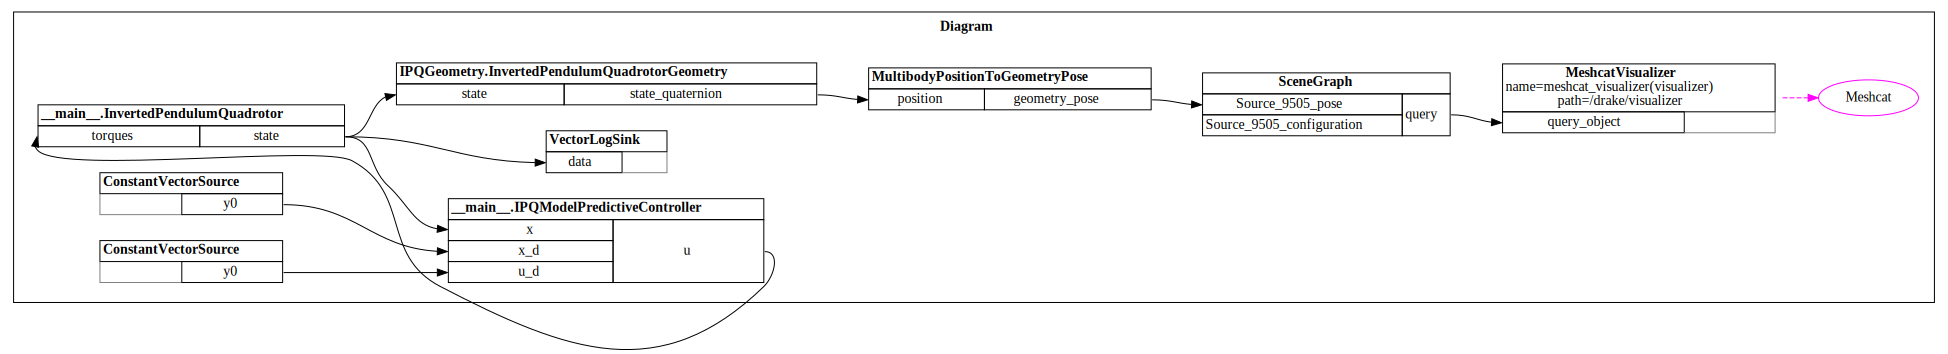

In [242]:
def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    # builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())

    final = np.zeros((16, ))
    final[2] = 0.3
    final_pose = builder.AddSystem(ConstantVectorSource(final))
    unit_torque = builder.AddSystem(ConstantVectorSource((plant._Mq*plant._g/4)*np.ones((4, ))))
    logger = builder.AddSystem(VectorLogSink(16, 0.01))
    # multiplexer = builder.AddSystem(Multiplexer([12,2]))
    # builder.Connect(plant.get_output_port(0), multiplexer.get_input_port(0))
    # builder.Connect(pplant.get_output_port(0), multiplexer.get_input_port(1))
    R = np.eye(4);
    Q = np.diag([30, 30, 10, 1, 1, 1, 50, 50, 1, 1, 1, 1, 1, 1, 50, 50]);
    Qf = Q;

    MPC = builder.AddSystem(IPQModelPredictiveController(Q, R, Qf))

    # x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
    # u_traj_source = builder.AddSystem(TrajectorySource(u_traj))
    builder.Connect(plant.get_output_port(0), logger.get_input_port(0))
    builder.Connect(MPC.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), MPC.get_input_port(0))
    builder.Connect(final_pose.get_output_port(0), MPC.get_input_port(1))
    builder.Connect(unit_torque.get_output_port(0), MPC.get_input_port(2))

    
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # add_box_to_environment()
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(0.5)
    context = simulator.get_mutable_context()


    context.SetTime(0.)

    initial_state = np.zeros(16,)
    initial_state[1] = +0.1
    initial_state[4] = +0.4
    initial_state[6] = -0.02
    context.SetContinuousState(initial_state)
    simulator.Initialize()
    # simulator.AdvanceTo(10.0)
    try:
        simulator.AdvanceTo(0)
    except Exception as e:
        print(e)
        pass
    return logger.FindLog(context).data(), context.get_time()

state_vector, t = quadrotor_example()

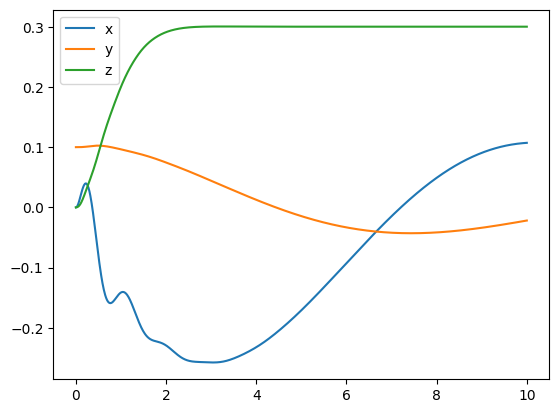

In [240]:
import matplotlib.pyplot as plt

state_list = state_vector[0,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[1,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[2,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
plt.legend(["x", "y", "z"], )
plt.show()

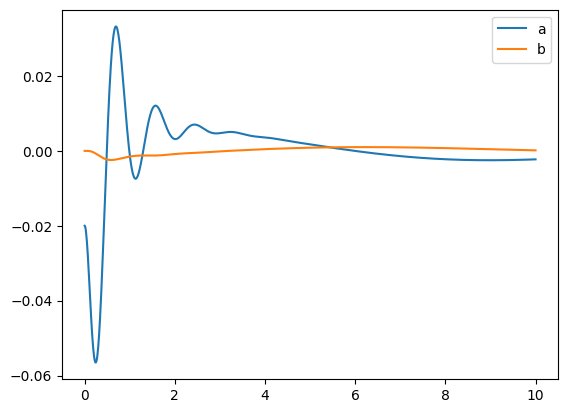

In [241]:
state_list = state_vector[6,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[7,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
plt.legend(["a", "b"], )
plt.show()

## 4. Collocation Trajectory Planner

This planner plots a trajectory given the controller dynamics using collocation.

In [353]:
import pydrake.math
from pydrake.autodiffutils import AutoDiffXd

class IPQCollocationTrajectory():
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, kF = 1.0, kM=0.0245):
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp

        self._g = 9.81

        self._kF = kF
        self._kM = kM
        
        self.n_x = 16
        self.n_u = 4
        
        self.umin = 0
        self.umax = 50
        
    def evaluate_dynamics(self, x, u):
        
        uF = self._kF*u
        Fz = np.array([sum(uF)])
    
        uM = self._kM*u
        M = np.array([
            self._Lq*(uF[1] - uF[3]),
            self._Lq*(uF[2] - uF[0]),
            uM[0] - uM[1] + uM[2] - uM[3]
        ]).T

        Fg = np.array([0, 0, -self._Mq * self._g]).T
        rpy = x[3:6]
        w = x[11:14]
    
        phi, theta, psi = tuple(rpy)
    
        gq = np.array([[np.sin(phi)*np.sin(psi) + np.cos(phi)*np.sin(theta)*np.cos(psi), 
                      -np.sin(phi)*np.cos(psi) + np.cos(phi)*np.sin(theta)*np.sin(psi),
                      np.cos(phi)*np.cos(theta)]]).T
    
        pDDt = (Fg + gq @ Fz)/self._Mq
    
        Zq = np.array([[ 1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        qDt = Zq @ w
        if(x.dtype == AutoDiffXd):
            wDt = pydrake.math.inv(self._Iq) @ np.cross(self._Iq @ w, w) + pydrake.math.inv(self._Iq) @ M
        else:
            wDt = np.linalg.inv(self._Iq) @ np.cross(self._Iq @ w, w) + np.linalg.inv(self._Iq) @ M
    
        a, b = x[6], x[7]
        a2 = pow(a,2)
        b2 = pow(b,2)
        ad, bd = x[14], x[15]
        ad2 = pow(ad,2)
        bd2 = pow(bd,2)
        Lp2 = pow(self._Lp,2)

        if(x.dtype == AutoDiffXd):
            eta = pydrake.math.sqrt(Lp2 - a2 - b2)
        else:
            eta = math.sqrt(Lp2 - a2 - b2)
        
        Hab = 4*bd2*(a2 - Lp2) - 8*ad*bd*a*b + 4*ad2*(b2 - Lp2) + 3*pow(eta,3)*self._g
        Fp = np.array([
            (a*Hab)/(4*Lp2*pow(eta,2)),
            (b*Hab)/(4*Lp2*pow(eta,2))
        ]).T
        Bp = np.array([[ 3*(a2 -Lp2)/(4*Lp2), (3*a*b)/(4*Lp2), (3*a*eta)/(4*Lp2)],
                      [(3*a*b)/(4*Lp2), 3*(b2 - Lp2)/(4*Lp2), (3*b*eta)/(4*Lp2)]])
    
        pdDDt = Fp + Bp @ pDDt
    
        DDt = np.concatenate((x[8:11], qDt.T, x[14:16], pDDt.T, wDt.T, pdDDt.T))
        return DDt.T
    
    def collocation_constraint_evaluator(self, dt, x_i, u_i, x_ip1, u_ip1):
        h_i = np.zeros(self.n_x,)
        # TODO: Add a dynamics constraint using x_i, u_i, x_ip1, u_ip1, dt
        # You should make use of the EvaluateDynamics() function to compute f(x,u)
        
        f_i = self.evaluate_dynamics(x_i, u_i)
        f_ip1 = self.evaluate_dynamics( x_ip1, u_ip1)
        
        s_i = ((x_i + x_ip1)/2) - (dt*(f_ip1 - f_i)/8)
        ds_i = (3*(x_ip1 - x_i)/(2*dt)) - ((f_i + f_ip1)/4)
        
        h_i = ds_i - self.evaluate_dynamics(s_i, (u_i + u_ip1)/2)
        
        return h_i
    
    def add_collocation_constraints(self, prog, N, x, u, timesteps):
        for i in range(N - 1):
            def CollocationConstraintHelper(vars):
              x_i = vars[:self.n_x]
              u_i = vars[self.n_x:self.n_x + self.n_u]
              x_ip1 = vars[self.n_x + self.n_u: 2*self.n_x + self.n_u]
              u_ip1 = vars[-self.n_u:]
              return self.collocation_constraint_evaluator(timesteps[i+1] - timesteps[i], x_i, u_i, x_ip1, u_ip1)
            b = np.zeros(self.n_x,)
            v = np.hstack((x[i], u[i], x[i+1], u[i+1]))
            cc = prog.AddConstraint(CollocationConstraintHelper, b, b, v)
            # print(cc)
          
    
    def find_IPQ_trajectory(self, N, initial_state, way_points, final_state, t0, tf, way_point_step = 20):
        print(f"t : {t0} -> {tf}")
        effort_limits = 20*np.ones([4,])
    
        # Create the mathematical program
        prog = MathematicalProgram()
        x = np.zeros((N, self.n_x), dtype="object")
        u = np.zeros((N, self.n_u), dtype="object")
        for i in range(N):
            x[i] = prog.NewContinuousVariables(self.n_x, "x_" + str(i))
            u[i] = prog.NewContinuousVariables(self.n_u, "u_" + str(i))
          
        timesteps = np.linspace(t0, tf, N)
        x0 = x[0]
        xf = x[-1]
    
        eq = prog.AddLinearEqualityConstraint(x0,initial_state)
        # print(eq)
        eq = prog.AddLinearEqualityConstraint(xf,final_state)
        # print(eq)
        eq = prog.AddLinearEqualityConstraint(u[-1],(self._Mq*self._g/4)*np.ones((self.n_u)))
        # print(eq)
        # for i, way_point in enumerate(way_points):
        #     print(way_point)
        #     eq = prog.AddLinearEqualityConstraint(x[way_point_step*(i+1),:3],way_point)
        #     print(eq)

        self.add_collocation_constraints(prog, N, x, u, timesteps)

        lb = self.umin*np.ones((N, self.n_u))
        ub = self.umax*np.ones((N, self.n_u))
        bc = prog.AddBoundingBoxConstraint(lb, ub, u)
        # print([1:-1]bc)

        for i in range(N):
            bc = prog.AddConstraint(x[i,6]*x[i,6] + x[i,7]*x[i,7], 0, self._Lp)
            # print(bc)

        ug = (self._Mq*self._g/4)*np.ones((N,self.n_u))
        xg = np.linspace(initial_state, final_state, N)
        # for _xg, _waypoint in zip(xg[1:-1], way_points):
        #     _xg[:2] = _waypoint
        # print(ug)
        prog.SetInitialGuess(u, ug)
        # print(xg)
        prog.SetInitialGuess(x, xg)
        
        # TODO: Add the cost function here
        cost = (timesteps[1] - timesteps[0])*(u[0].T @ u[0] + u[1].T @ u[1])/2
        for i in range(1, N-1):
          cost += (timesteps[i+1] - timesteps[i])*(u[i].T @ u[i] + u[i+1].T @ u[i+1])/2
        c = prog.AddQuadraticCost(cost)
        # print(c)
        # Set up solver
        result = Solve(prog)
        
        x_sol = result.GetSolution(x)
        u_sol = result.GetSolution(u)
        
        print('optimal cost: ', result.get_optimal_cost())
        # print('x_sol: ', x_sol)
        # print('u_sol: ', u_sol)
        
        print(result.get_solution_result())

        # Reconstruct the trajectory
        xdot_sol = np.zeros(x_sol.shape)
        for i in range(N):
            xdot_sol[i] = self.evaluate_dynamics(x_sol[i], u_sol[i])

        x_traj = PiecewisePolynomial.CubicHermite(timesteps, x_sol.T, xdot_sol.T)
        u_traj = PiecewisePolynomial.ZeroOrderHold(timesteps, u_sol.T)
        
        return x_traj, u_traj, prog, prog.GetInitialGuess(x), prog.GetInitialGuess(u)

In [323]:
N = 30

initial_state = np.zeros(16,)
initial_state[1] = +0.1
initial_state[4] = +0.4
initial_state[6] = -0.02
final_state = np.zeros(16)
final_state[2] = 0.3

tf = 5.0

cc = IPQCollocationTrajectory()
x_traj, u_traj, prog, xg, ug = cc.find_IPQ_trajectory(N, initial_state, [], final_state, 0, tf)

t : 0 -> 5.0
optimal cost:  72.8139083093993
SolutionResult.kSolutionFound


In [278]:
N = 10

x = -0.5
y = 0.5
z = 0.5
tf = 4.0
Ns = 4

initial_state = np.zeros(16)
initial_state[1] = y
initial_state[2] = z

cc = IPQCollocationTrajectory()
# x_trajectories = []
# u_trajectories = []

waypoints = []

t = np.linspace(0, tf, Ns)
f = 3*tf/Ns
for i in range(Ns-2):
    t0 = t[i]
    t1 = t[i+1]

    final_state = np.zeros(16)
    final_state[0] = x*np.sin(f*t1)
    final_state[1] = y*np.cos(f*t1)
    final_state[2] = z
    # final_state[8] = x*f*np.cos(f*t1)
    # final_state[9] = -y*f*np.sin(f*t1)
    # final_state[10] = 0

    print(initial_state)
    print(final_state)
    
    x_traj, u_traj, prog, xg, ug = cc.find_IPQ_trajectory(N, initial_state, [], final_state, t0, t1)

    x_trajectories.append(x_traj)
    u_trajectories.append(u_traj)

    initial_state = final_state

final_state = np.zeros(16)
final_state[0] = x*np.sin(f*t[-1])
final_state[1] = y*np.cos(f*t[-1])
final_state[2] = z

# waypoints = [np.array([x*np.sin(f*_t), y*np.cos(f*_t)]) for _t in t[1:-1]]
# print(len(waypoints))

# final_state = np.zeros(16)
# final_state[0] = x*np.sin(f*t[-1])
# final_state[1] = y*np.cos(f*t[-1])
# final_state[2] = z

x_traj, u_traj, prog, xg, ug = cc.find_IPQ_trajectory(N, initial_state, [], final_state, t[-2], tf)

x_trajectories.append(x_traj)
u_trajectories.append(u_traj)

[0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[ 0.37840125 -0.32682181  0.5         0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
t : 0.0 -> 1.3333333333333333
optimal cost:  128.30341697264615
SolutionResult.kSolutionFound
[ 0.37840125 -0.32682181  0.5         0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[-0.49467912 -0.07275002  0.5         0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
t : 1.3333333333333333 -> 2.6666666666666665


RuntimeError: Exception while evaluating SNOPT costs and constraints: 'KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /tmp/ipykernel_664/2964104232.py(60): evaluate_dynamics
  /tmp/ipykernel_664/2964104232.py(96): collocation_constraint_evaluator
  /tmp/ipykernel_664/2964104232.py(107): CollocationConstraintHelper
  /tmp/ipykernel_664/2964104232.py(168): find_IPQ_trajectory
  /tmp/ipykernel_664/3580681718.py(36): <module>
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3577): run_code
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3517): run_ast_nodes
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3334): run_cell_async
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3130): _run_cell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3075): run_cell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/ipkernel.py(449): do_execute
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/ipkernel.py(362): execute_request
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /usr/lib/python3.12/asyncio/events.py(88): _run
  /usr/lib/python3.12/asyncio/base_events.py(1987): _run_once
  /usr/lib/python3.12/asyncio/base_events.py(641): run_forever
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/tornado/platform/asyncio.py(205): start
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelapp.py(739): start
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
'

In [ ]:
x_traj = CompositeTrajectory(x_trajectories)
u_traj = CompositeTrajectory(u_trajectories)
# x_traj = x_trajectories[0]
# u_traj = u_trajectories[0]

In [ ]:
initial_state = np.zeros(16)
initial_state[1] = y
initial_state[2] = z

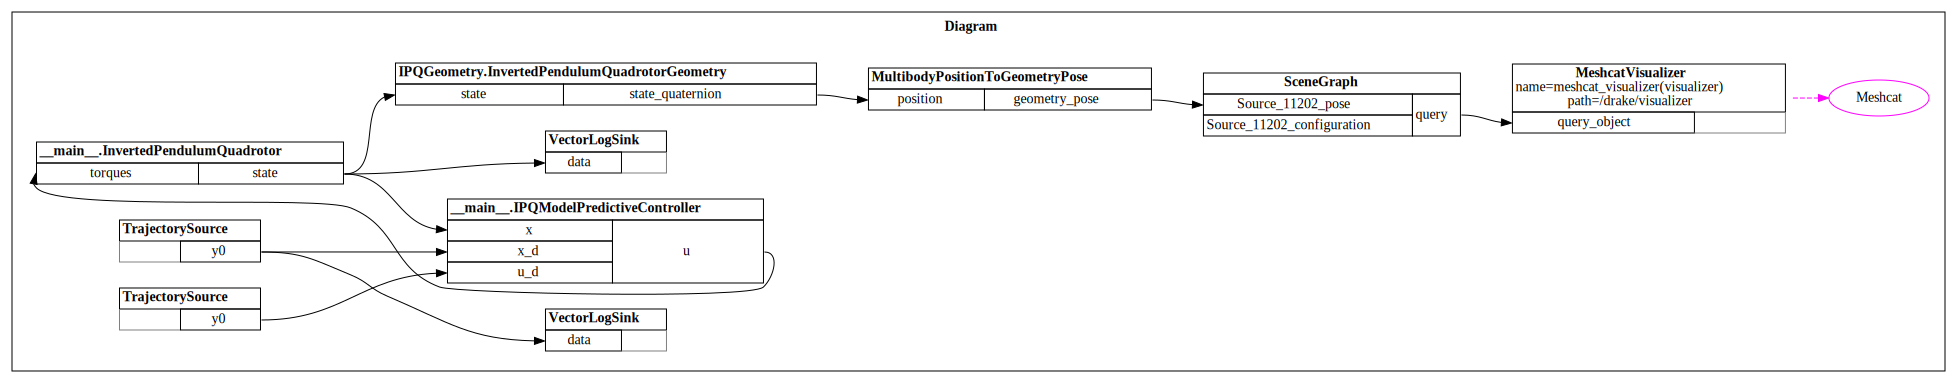

In [319]:
from pydrake.all import Sphere

def add_box_to_environment():
    visual_box_sdf = """<?xml version="1.0"?>
    <sdf version="1.7">
      <model name="CompliantBox">
        <pose>0 0 0 0 0 0</pose>
        <link name="compliant_box">
          <visual name="visual">
            <geometry>
              <box>
                <size>0.10 0.20 0.40</size>
              </box>
            </geometry>
            # <material>
            #   <diffuse>1.0 1.0 1.0 0.5</diffuse>
            # </material>
          </visual>
        </link>
      </model>
    </sdf>
    """

    cylinder_sdf = """<?xml version="1.0"?>
    <sdf version="1.7">
      <model name="cylinder">
        <pose>0 0 0 0 0 0</pose>
        <link name="cylinder_link">
          <inertial>
            <mass>1.0</mass>
            <inertia>
              <ixx>0.005833</ixx>
              <ixy>0.0</ixy>
              <ixz>0.0</ixz>
              <iyy>0.005833</iyy>
              <iyz>0.0</iyz>
              <izz>0.005</izz>
            </inertia>
          </inertial>
          <collision name="collision">
            <geometry>
              <cylinder>
                <radius>0.1</radius>
                <length>0.2</length>
              </cylinder>
            </geometry>
          </collision>
          <visual name="visual">
            <geometry>
              <cylinder>
                <radius>0.1</radius>
                <length>0.2</length>
              </cylinder>
            </geometry>
            <material>
              <diffuse>1.0 1.0 1.0 1.0</diffuse>
            </material>
          </visual>
        </link>
      </model>
    </sdf>
    """
    # Visualize the SDFormat string you just defined.
    visualizer = ModelVisualizer(meshcat=meshcat)
    print(visualizer)
    a = visualizer.parser().AddModelsFromString(visual_box_sdf, "sdf")
    print(a)
    visualizer.Run(loop_once=True)

def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    # builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    
    # unit_torque = builder.AddSystem(ConstantVectorSource([2, 2, 2, 2]))
    # multiplexer = builder.AddSystem(Multiplexer([12,2]))
    # builder.Connect(plant.get_output_port(0), multiplexer.get_input_port(0))
    # builder.Connect(pplant.get_output_port(0), multiplexer.get_input_port(1))
    R = np.eye(4);
    Q = np.diag([100, 100, 40, 20, 20, 20, 40, 40, 1, 1, 1, 1, 1, 1, 100, 100]);
    Qf = Q;

    MPC = builder.AddSystem(IPQModelPredictiveController(Q, R, Qf))
    cc_logger = builder.AddSystem(VectorLogSink(16, 0.01))
    state_logger = builder.AddSystem(VectorLogSink(16, 0.01))

    x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
    u_traj_source = builder.AddSystem(TrajectorySource(u_traj))
    
    builder.Connect(MPC.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), MPC.get_input_port(0))
    builder.Connect(plant.get_output_port(0), state_logger.get_input_port(0))
    builder.Connect(x_traj_source.get_output_port(0), MPC.get_input_port(1))
    builder.Connect(x_traj_source.get_output_port(0), cc_logger.get_input_port(0))
    builder.Connect(u_traj_source.get_output_port(0), MPC.get_input_port(2))

    
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # add_box_to_environment()
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(0.5)
    context = simulator.get_mutable_context()


    context.SetTime(0.)

    context.SetContinuousState(initial_state)
    simulator.Initialize()
    # simulator.AdvanceTo(10.0)
    try:
        simulator.AdvanceTo(tf)
    except Exception as e:
        print(e)
        pass
    return state_logger.FindLog(context).data(),cc_logger.FindLog(context).data(), context.get_time()

state_vector, cc_vector, t = quadrotor_example()

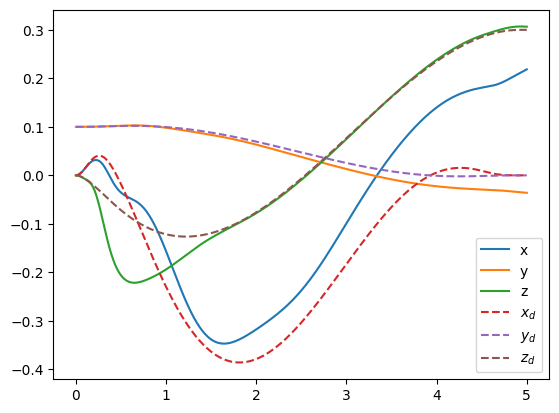

In [320]:
state_list = state_vector[0,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[1,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[2,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = cc_vector[0,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
state_list = cc_vector[1,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
state_list = cc_vector[2,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
plt.legend(["x", "y", "z", r"$x_d$", r"$y_d$", r"$z_d$"], )
plt.show()

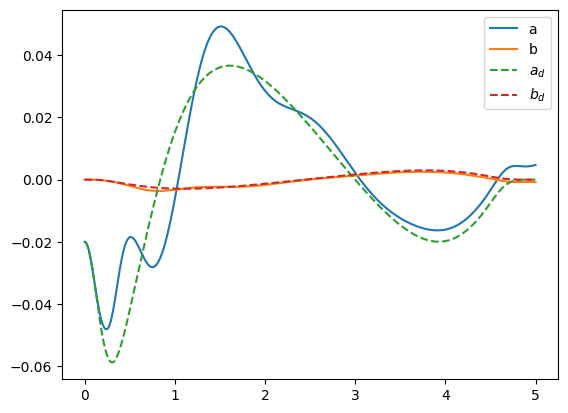

In [321]:
state_list = state_vector[6,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[7,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = cc_vector[6,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
state_list = cc_vector[7,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
plt.legend(["a", "b", r"$a_d$", r"$b_d$"], )
plt.show()

## 5.Nonlinear Controller Design for Quadrotor with Inverted Pendulum

### 5.1 CLF-QP

Implements control of quadrotor as a CLF QP

In [121]:
class QuadrotorCLFQP(LeafSystem):
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Q, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, kF = 1.0, kM=0.0245, is_output_tracking:bool = True):

        LeafSystem.__init__(self)
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp
        
        self._kF = kF
        self._kM = kM
        self._g = 9.81

        self.umin = 0
        self.umax = 20

        self.n_x = 12
        self.n_u = 4

        self.Q = Q

        self.is_output_tracking = is_output_tracking

        ''' Declare Input Ports '''
        # State input port
        self.robot_state_input_port_index = self.DeclareVectorInputPort(
            "x", self.n_x
        ).get_index()

        if self.is_output_tracking:
            self.output_tracking_input_port = self.DeclareVectorInputPort(
                "yd", 4
            ).get_index() # [pz, phi, theta, psi]
        else:
            self.output_tracking_input_port = self.DeclareVectorInputPort(
                "Pxd", 3
            ).get_index() # [px, py, pz]

        # Define the output ports
        self.torque_output_port = self.DeclareVectorOutputPort(
            "u", self.n_u, self.CalcTorques
        )

    def add_CLF_constraint(self, prog, x_current, y_target, AxB, Lfh, v):
        pz = x_current[2]
        # print(x_current)
        vz = x_current[8]
        
        rpy = x_current[3:6]
        w = x_current[9:12]
        
        phi, theta, psi = tuple(rpy)
        Wx, Wy, Wz = tuple(w)

        Zq = np.array([[ 1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
               [0, np.cos(phi), -np.sin(phi)],
               [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        qDt = Zq @ w

        F = np.block([
          [np.zeros((4,4)), np.eye(4)],
            [np.zeros((4,4)), np.zeros((4, 4))]
        ])

        G = np.block(
            [
                [np.zeros((4, 4))],
                [np.eye(4)]
            ]
        )
        P = solve_continuous_are(F, G, self.Q, np.eye(4))
        print(np.array([[pz, phi, theta, psi] - y_target]).T)
        eta = np.block([
            [-np.array([[pz, phi, theta, psi] - y_target]).T],
            [vz],
            [np.array([qDt]).T]
        ])
        eta[0] = -eta[0]
        # P = np.eye(8)
        
        lambda_q, _ = np.linalg.eig(self.Q)
        lambda_p, _ = np.linalg.eig(P)
        c3 = min(lambda_q)/max(lambda_p)

        lc = prog.AddLinearConstraint(-2 * eta.T @ P @ G, eta.T @ (F.T @ P + P @ F + c3 * P) @ eta, np.inf, v)

        lc = prog.AddLinearConstraint(np.linalg.inv(AxB), np.linalg.inv(AxB) @ Lfh + np.ones((4,1))*self.umin, np.linalg.inv(AxB) @ Lfh + np.ones((4,1))*self.umax, v)
        
    def add_cost(self, prog, v):
        # TODO: add cost.
    
        c = prog.AddQuadraticCost(v.T @ v)
        # print(c)
        
    def CalcTorques(self, context: Context, output: BasicVector) -> None:
        x_current = self.EvalVectorInput(context, self.robot_state_input_port_index).get_value()
        y_target = self.EvalVectorInput(context, self.output_tracking_input_port).get_value()

        prog = MathematicalProgram()
        v = prog.NewContinuousVariables(4, "v")

        pz = x_current[2]
        vz = x_current[8]
        
        rpy = x_current[3:6]
        w = x_current[9:12]
        
        phi, theta, psi = tuple(rpy)
        Wx, Wy, Wz = tuple(w)

        Zq = np.array([[ 1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
               [0, np.cos(phi), -np.sin(phi)],
               [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        qDt = Zq @ w

        dqDt = np.array([[Wy*np.cos(phi)*np.tan(theta) - Wz*np.sin(phi)*np.tan(theta), (Wz*np.cos(phi) + Wy*np.sin(phi))*(pow(np.tan(theta),2) + 1), 0],
                        [-Wz*np.cos(phi) - Wy*np.sin(phi), 0, 0],
                        [Wy*np.cos(phi)/np.cos(theta) - Wz*np.sin(phi)/np.cos(theta), Wz*np.cos(phi)*np.sin(theta)/pow(np.cos(theta),2) + Wy*np.sin(phi)*np.sin(theta)/pow(np.cos(theta),2), 0]])

        Lfh = np.block([[self._g], 
                        [np.array([dqDt @ qDt + Zq @ np.linalg.inv(self._Iq) @ np.cross(self._Iq @ w, w)]).T]
                       ])
        
        Ax = np.block([
            [-np.cos(phi)*np.cos(theta)/self._Mq, np.zeros((1, 3))],
            [np.zeros((3, 1)), np.array(Zq @ np.linalg.inv(self._Iq))]
        ])
        B = np.array([
            [self._kF, self._kF, self._kF, self._kF],
            [0, self._Lq*self._kF, 0, -self._Lq*self._kF],
            [-self._Lq*self._kF, 0 , self._Lq*self._kF, 0],
            [self._kM, -self._kM, self._kM, -self._kM]
        ])

        AxB = Ax @ B

        self.add_CLF_constraint(prog, x_current, y_target, AxB, Lfh, v)
        self.add_cost(prog, v)

        solver = OsqpSolver()
        result = solver.Solve(prog)

        v = result.GetSolution(v)

        # F = np.block([
        #   [np.zeros((4,4)), np.eye(4)],
        #     [np.zeros((4,4)), np.zeros((4, 4))]
        # ])

        # G = np.block(
        #     [
        #         [np.zeros((4, 4))],
        #         [np.eye(4)]
        #     ]
        # )
        # P = solve_continuous_are(F, G, self.Q, np.eye(4))
        # eta = np.block([
        #     [np.array([[pz, phi, theta, psi] - y_target]).T],
        #     [vz],
        #     [np.array([qDt]).T]
        # ])
        # v = -G.T @ P @ eta
        # print(v[0])

        # print(Lfh + v)
        print(f"v[0] : {v[0]}, v[1] : {v[1]}, v[2] : {v[2]}, v[3] : {v[3]}")
        # print(-Lfh + np.array([v]).T)
        u = np.linalg.inv(AxB) @ (-Lfh - np.array([v]).T)
        # print(u)
        
        # x = -Lfh + np.array([v]).T
        # print(x)
        # x = -Lfh - v
        # x[0] = -self._g - v[0]
        # u = np.linalg.inv(AxB) @ (x)
        output.SetFromVector(u)

        
        

        
        

### 5.2 LQR

Implements control of Pendulum using LQR with Phi and Theta as control inputs

In [122]:
from scipy.linalg import solve_continuous_are
class IPQ_LQR(LeafSystem):
    def __init__(self, Q, R, Lp:float = 1):

        LeafSystem.__init__(self)
        self.Q = Q
        self.R = R
        self._Lp = Lp
        self._g = 9.81
        
        ''' Declare Input Ports '''
        # State input port
        self.robot_state_input_port_index = self.DeclareVectorInputPort(
            "x", 16
        ).get_index()

        # Define the output ports
        self.torque_output_port = self.DeclareVectorOutputPort(
            "u", 2, self.CalcTorques
        )     
    def continuous_time_linearized_dynamics(self):
        A = np.zeros((8, 8))
        A[0, 4] = A[1, 5] = A[2, 6] = A[3, 7] = 1
        A[4,0] = A[5,1] = 3*self._g/(4*self._Lp)

        B = np.zeros((8, 2))
        B[4, 1] = -3*self._g/4
        B[5, 0] = -B[4, 1]
        B[6, 1] = self._g
        B[7, 0] = -B[6, 1]

        return A, B

    def calculate_lqr(self, state):
        A, B = self.continuous_time_linearized_dynamics()
        K, _ = LinearQuadraticRegulator(A,B,self.Q,self.R)
        eta = np.array([state]).T
        u = -K @ eta
        print(u)
        return u
    
    def CalcTorques(self, context: Context, output: BasicVector) -> None:
        x_current = self.EvalVectorInput(context, self.robot_state_input_port_index).get_value()
        print(x_current)
        x = np.concatenate((x_current[6:8], x_current[0:2], x_current[14:16], x_current[8:10]))
        usol = self.calculate_lqr(x)
        print(f"Phi-d : {usol[0]}, Theta-d : {usol[1]}")
        output.SetFromVector(usol)

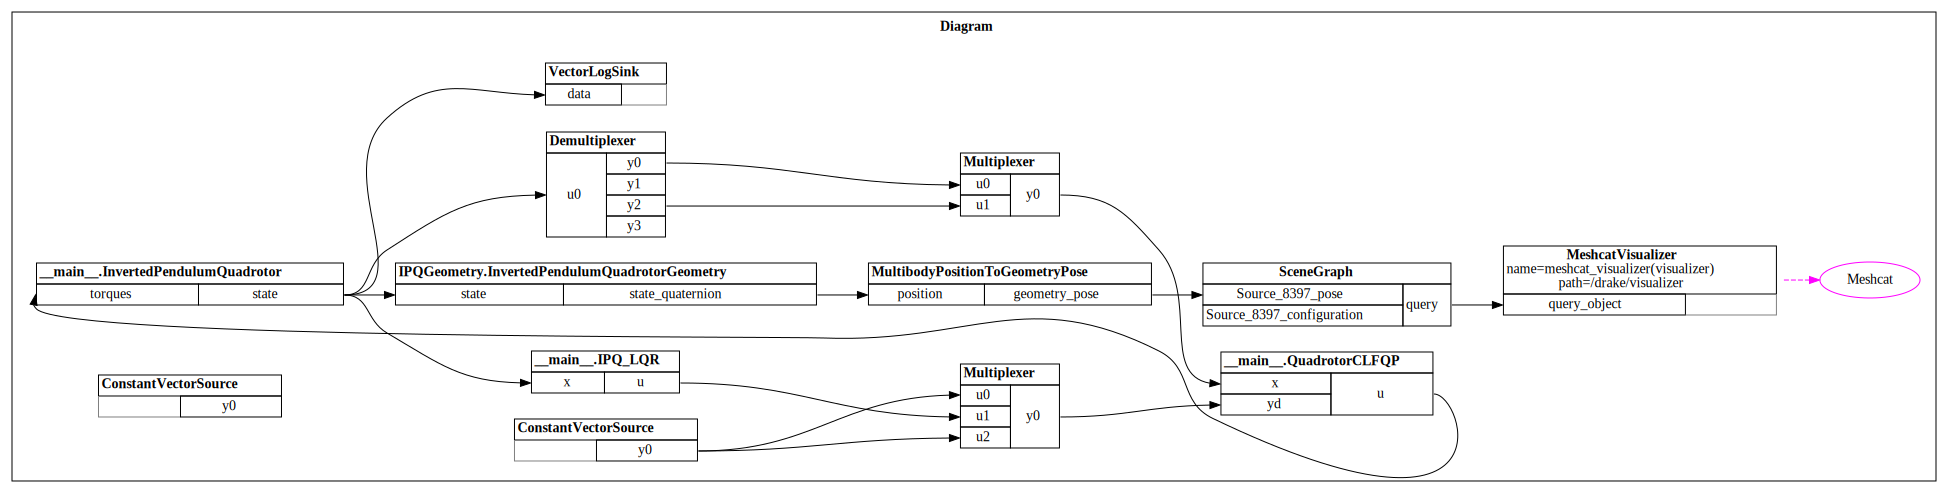

['Clone', 'DisableCaching', 'EnableCaching', 'FreezeCache', 'SetAbstractState', 'SetAccuracy', 'SetAllCacheEntriesOutOfDate', 'SetContinuousState', 'SetDiscreteState', 'SetStateAndParametersFrom', 'SetTime', 'SetTimeAndContinuousState', 'SetTimeStateAndParametersFrom', 'UnfreezeCache', '__class__', '__copy__', '__deepcopy__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_del_orig', 'get_abstract_parameter', 'get_abstract_state', 'get_accuracy', 'get_continuous_state', 'get_continuous_state_vector', 'get_discrete_state', 'get_discrete_state_vector', 'get_mutable_abstract_parameter', 'get_mutable_abstract_state', 'get_mutable_continuous_state', 'get_mutable_continuous_state_vector', 'get_mutable_d

/tmp/ipykernel_664/1631543227.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lc = prog.AddLinearConstraint(-2 * eta.T @ P @ G, eta.T @ (F.T @ P + P @ F + c3 * P) @ eta, np.inf, v)


v[0] : 9.245338402715457e-19, v[1] : 1.7537071057500227e-16, v[2] : -0.012303839832873253, v[3] : -4.412757367476288e-17
[-4.90389713e-04  4.32767170e-19  6.79253905e-19 -6.26740625e-17
 -9.97799205e-03  1.90107403e-19  3.70052038e-04 -3.25255291e-19
 -9.80448571e-03  1.88367517e-17  2.17746967e-18 -1.18294277e-15
  6.19349292e-04  6.87506677e-17  7.44390712e-03 -1.41716755e-17]
[[9.63209697e-17]
 [5.74850901e-02]]
Phi-d : [9.63209697e-17], Theta-d : [0.05748509]
[[ 6.79253905e-19]
 [-1.58995032e-16]
 [-6.74630821e-02]
 [ 1.90107403e-19]]
v[0] : -2.533069723259186e-19, v[1] : 1.5369900098519812e-16, v[2] : -0.012284159253565845, v[3] : -1.3536663208240466e-17
[-5.36348239e-04  5.21064444e-19  6.89460794e-19 -6.82223207e-17
 -9.97508885e-03  5.12210237e-19  4.04945353e-04 -3.91685020e-19
 -1.02633327e-02  2.17188355e-17 -3.19457722e-18 -1.18294291e-15
  6.76931288e-04  7.80448104e-17  7.80080466e-03 -1.63444558e-17]
[[1.11652690e-16]
 [6.08551183e-02]]
Phi-d : [1.1165269e-16], Theta-d :

In [213]:
def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    # builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())

    constant_state = np.zeros((4, 1))
    constant_state[0] = 0.1
    # constant_state[1] = 0.1
    constant_state = builder.AddSystem(ConstantVectorSource(constant_state))

    zero_value = builder.AddSystem(ConstantVectorSource([0]))
    position_multiplexer = builder.AddSystem(Multiplexer([1, 2, 1]))
    demultiplexer = builder.AddSystem(Demultiplexer([6, 2, 6, 2]))
    multiplexer = builder.AddSystem(Multiplexer([6, 6]))
    # builder.Connect(plant.get_output_port(0), multiplexer.get_input_port(0))
    # builder.Connect(pplant.get_output_port(0), multiplexer.get_input_port(1))
    logger = builder.AddSystem(VectorLogSink(16, 0.01))

    Q = 10*np.diag([1, 1, 1, 1, 1, 1, 1, 1])
    R = np.diag([1, 1])
    IP_LQR = builder.AddSystem(IPQ_LQR(Q, R))

    Q = np.diag([1, 10, 10, 1, 1, 1 ,10 ,10])
    CLF_QP = builder.AddSystem(QuadrotorCLFQP(Q))

    builder.Connect(plant.get_output_port(0), logger.get_input_port(0))
    
    builder.Connect(CLF_QP.get_output_port(0), plant.get_input_port(0))

    builder.Connect(plant.get_output_port(0), IP_LQR.get_input_port(0))
    builder.Connect(zero_value.get_output_port(0), position_multiplexer.get_input_port(0))
    builder.Connect(IP_LQR.get_output_port(0), position_multiplexer.get_input_port(1))
    builder.Connect(zero_value.get_output_port(0), position_multiplexer.get_input_port(2))
    
    builder.Connect(plant.get_output_port(0), demultiplexer.get_input_port(0))
    builder.Connect(demultiplexer.get_output_port(0), multiplexer.get_input_port(0))
    builder.Connect(demultiplexer.get_output_port(2), multiplexer.get_input_port(1))
    builder.Connect(multiplexer.get_output_port(0), CLF_QP.get_input_port(0))
    
    builder.Connect(position_multiplexer.get_output_port(0), CLF_QP.get_input_port(1))
    # builder.Connect(plant.get_output_port(0), CLF_QP.get_input_port(0))
    # builder.Connect(constant_state.get_output_port(0), CLF_QP.get_input_port(1))
    
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()


    state = np.zeros(16,)
    state[4] = -0.01
    # state[4] = +0.4
    # state[6] = 0.01
    context.SetContinuousState(state)
    print(dir(context))
    simulator.Initialize()
    dt = 0.1
    t = 0
    context.SetTime(0.)
    # state_vector = []
    # while t < 15:
    #     t += dt
    #     state_vector.append(np.array(context.get_continuous_state().get_mutable_vector()))
    try:
        simulator.AdvanceTo(10)
    except Exception:
        pass
    return logger.FindLog(context).data(), context.get_time()

state_vector, t = quadrotor_example()

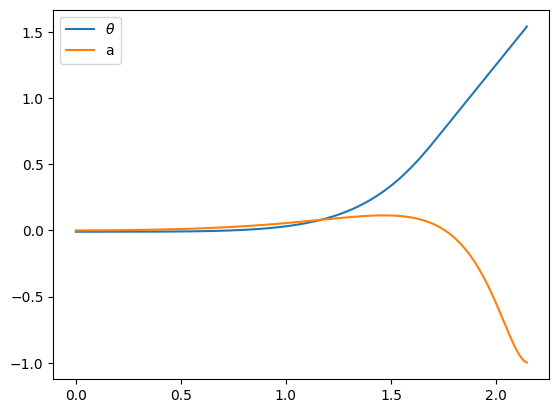

In [211]:
import matplotlib.pyplot as plt

state_list = state_vector[4,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[6,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
plt.legend([r"$\theta$", "a"], )
plt.show()

## 6. Analysis

In [ ]:
state_list

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, 5, len(state_list)), np.array(state_list)[:,0])
plt.show()

In [ ]:
plt.plot(np.linspace(0, 5, len(state_list)), np.array(state_list)[:,1])
plt.show()

In [ ]:
plt.plot(np.linspace(0, 5, len(state_list)), np.array(state_list)[:,8])
plt.show()

## 7. Obstacle Avoidance - RRT*

In [341]:
import rrt_star.rrt as rrt
import importlib
importlib.reload(rrt)

<module 'rrt_star.rrt' from '/home/stephen/Workspace/fall-2024/MEAM-5170/project/Inverted-Pendulum-Quadrotor/src/rrt_star/rrt.py'>

In [342]:
map_struct = rrt.loadmap("rrt_star/map1.txt")
start = np.array([-1.5, 0, 0])
goal = np.array([1.5, 0, 0])
add_obstacles_to_environment(map_struct)

path = rrt.rrt(deepcopy(map_struct), deepcopy(start), deepcopy(goal))


In [ ]:
path

In [354]:
N = 150

x_trajectories = []
u_trajectories = []

t0 = 0
for initial_position, final_position in zip(path[0:path.shape[0],:],path[1:path.shape[0], :]):
    tf = t0 + 3
    
    initial_state = np.zeros(16)
    initial_state[0:3] = initial_position
    
    final_state = np.zeros(16)
    final_state[0:3] = final_position
    
    cc = IPQCollocationTrajectory()
    x_traj, u_traj, prog, xg, ug = cc.find_IPQ_trajectory(N, initial_state, [], final_state, t0, tf)
    
    x_trajectories.append(x_traj)
    u_trajectories.append(u_traj)

    t0 = tf

t : 0 -> 3
optimal cost:  43.43323953536073
SolutionResult.kSolutionFound
t : 3 -> 6
optimal cost:  43.67482403873129
SolutionResult.kSolutionFound
t : 6 -> 9
optimal cost:  44.65421277334421
SolutionResult.kSolutionFound
t : 9 -> 12
optimal cost:  44.81824397903952
SolutionResult.kSolutionFound
t : 12 -> 15
optimal cost:  43.653629314731035
SolutionResult.kSolutionFound


In [55]:
N = 100

x_trajectories = []
u_trajectories = []

t0 = 0
tf = t0 + 15

initial_state = np.zeros(16)
initial_state[0:3] = path[0,:]

final_state = np.zeros(16)
final_state[0:3] = path[-1,:]

cc = IPQCollocationTrajectory()
x_traj, u_traj, prog, xg, ug = cc.find_IPQ_trajectory(N, initial_state, path[1:-1,:], final_state, t0, tf)

t : 0 -> 15
[-1.09242551  0.4471651  -1.0895249 ]
LinearEqualityConstraint
x_20(0) == -1.09243
x_20(1) == 0.447165
x_20(2) == -1.08952

[-0.05403748  0.74318816 -0.30074653]
LinearEqualityConstraint
x_40(0) == -0.0540375
x_40(1) == 0.743188
x_40(2) == -0.300747

[1.10670165 1.07387093 0.56524633]
LinearEqualityConstraint
x_60(0) == 1.1067
x_60(1) == 1.07387
x_60(2) == 0.565246



RuntimeError: Exception while evaluating SNOPT costs and constraints: 'KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /tmp/ipykernel_664/162021325.py(26): evaluate_dynamics
  /tmp/ipykernel_664/162021325.py(96): collocation_constraint_evaluator
  /tmp/ipykernel_664/162021325.py(107): CollocationConstraintHelper
  /tmp/ipykernel_664/162021325.py(168): find_IPQ_trajectory
  /tmp/ipykernel_664/2327874299.py(16): <module>
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3577): run_code
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3517): run_ast_nodes
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3334): run_cell_async
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3130): _run_cell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py(3075): run_cell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/ipkernel.py(449): do_execute
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/ipkernel.py(362): execute_request
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /usr/lib/python3.12/asyncio/events.py(88): _run
  /usr/lib/python3.12/asyncio/base_events.py(1987): _run_once
  /usr/lib/python3.12/asyncio/base_events.py(641): run_forever
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/tornado/platform/asyncio.py(205): start
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel/kernelapp.py(739): start
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/stephen/Workspace/fall-2024/MEAM-5170/project/meam517-env/lib/python3.12/site-packages/ipykernel_launcher.py(18): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
'

In [356]:
x_traj = CompositeTrajectory(x_trajectories)
u_traj = CompositeTrajectory(u_trajectories)
initial_state= np.zeros(16)
initial_state[0:3] = path[0]

In [329]:
def add_obstacles_to_environment(map_struct):
    
    # Visualize the SDFormat string you just defined.
    visualizer = ModelVisualizer(meshcat=meshcat)
    for obstacle in map_struct.obstacles:
        xmin, ymin, zmin, xmax, ymax, zmax = obstacle
        l, w, h = (xmax-xmin), (ymax-ymin), (zmax-zmin)
        x, y, z = xmin + l/2, ymin + w/2, zmin + h/2
        visual_box_sdf = f"""<?xml version="1.0"?>
                                <sdf version="1.7">
                                  <model name="CompliantBox">
                                    <pose>{x} {y} {z} 0 0 0</pose>
                                    <link name="compliant_box">
                                      <visual name="visual">
                                        <geometry>
                                          <box>
                                            <size>{l} {w} {h}</size>
                                          </box>
                                        </geometry>
                                        # <material>
                                        #   <diffuse>1.0 1.0 1.0 0.5</diffuse>
                                        # </material>
                                      </visual>
                                    </link>
                                  </model>
                                </sdf>
                                """     
        visualizer.parser().AddModelsFromString(visual_box_sdf, "sdf")
    visualizer.Run(loop_once=True)

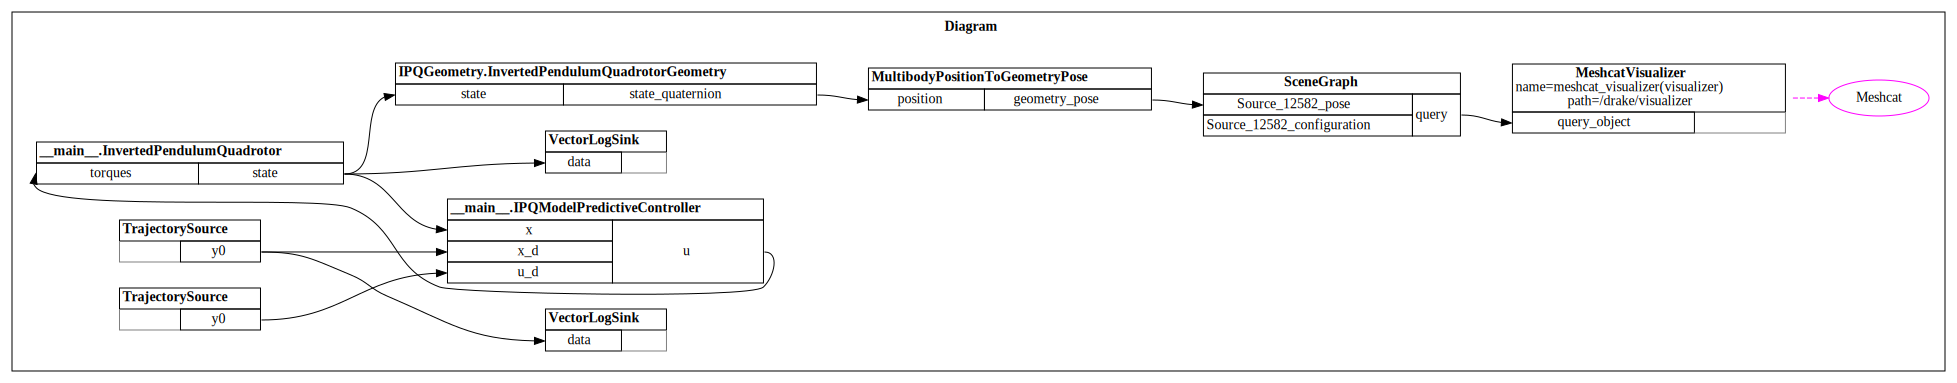

In [357]:
from pydrake.all import Sphere



def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    # builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    
    # unit_torque = builder.AddSystem(ConstantVectorSource([2, 2, 2, 2]))
    # multiplexer = builder.AddSystem(Multiplexer([12,2]))
    # builder.Connect(plant.get_output_port(0), multiplexer.get_input_port(0))
    # builder.Connect(pplant.get_output_port(0), multiplexer.get_input_port(1))
    R = np.eye(4);
    Q = np.diag([100, 100, 40, 20, 20, 20, 40, 40, 1, 1, 1, 1, 1, 1, 100, 100]);
    Qf = Q;

    MPC = builder.AddSystem(IPQModelPredictiveController(Q, R, Qf))

    x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
    u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

    cc_logger = builder.AddSystem(VectorLogSink(16, 0.01))
    state_logger = builder.AddSystem(VectorLogSink(16, 0.01))
    
    builder.Connect(MPC.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), MPC.get_input_port(0))
    builder.Connect(plant.get_output_port(0), state_logger.get_input_port(0))
    builder.Connect(x_traj_source.get_output_port(0), cc_logger.get_input_port(0))
    builder.Connect(x_traj_source.get_output_port(0), MPC.get_input_port(1))
    builder.Connect(u_traj_source.get_output_port(0), MPC.get_input_port(2))

    
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    add_obstacles_to_environment(map_struct)
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(0.5)
    context = simulator.get_mutable_context()


    context.SetTime(0.)

    # state = np.zeros(16,)
    #state[1] = +0.1
    # state[4] = +0.4
    # state[6] = -0.02
    context.SetContinuousState(initial_state)
    simulator.Initialize()
    # simulator.AdvanceTo(10.0)
    try:
        simulator.AdvanceTo(tf)
    except Exception as e:
        print(e)
        pass
    return state_logger.FindLog(context).data(),cc_logger.FindLog(context).data(), context.get_time()

state_vector, cc_vector, t = quadrotor_example()

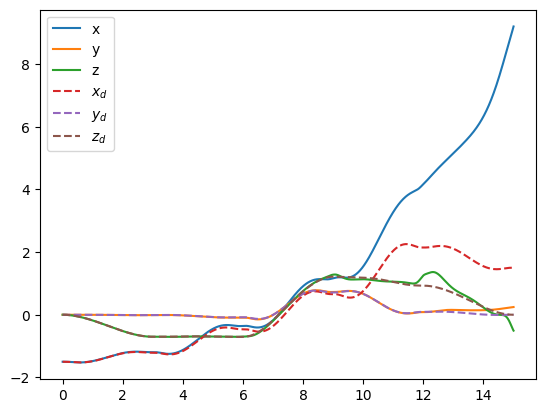

In [351]:
state_list = state_vector[0,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[1,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[2,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = cc_vector[0,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
state_list = cc_vector[1,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
state_list = cc_vector[2,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
plt.legend(["x", "y", "z", r"$x_d$", r"$y_d$", r"$z_d$"], )
plt.show()

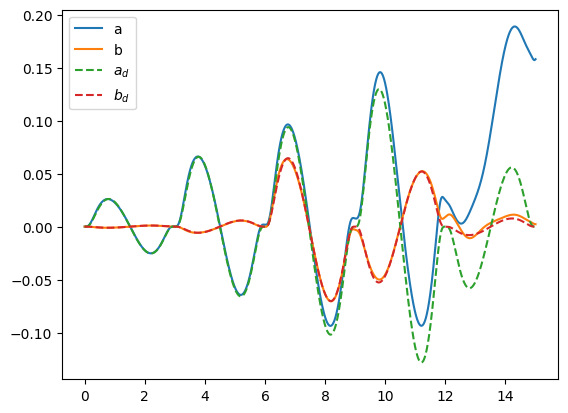

In [352]:
state_list = state_vector[6,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = state_vector[7,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list)
state_list = cc_vector[6,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
state_list = cc_vector[7,:]
plt.plot(np.linspace(0, t, len(state_list)), state_list, linestyle='--')
plt.legend(["a", "b", r"$a_d$", r"$b_d$"], )
plt.show()